In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import build_swath, inversion, inversion2, make_error_over_time
import glob2 as glob

In [2]:
alpha_std = np.arange(5e-4, 3.05e-2, 1e-3)
alpha_std

array([0.0005, 0.0015, 0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075,
       0.0085, 0.0095, 0.0105, 0.0115, 0.0125, 0.0135, 0.0145, 0.0155,
       0.0165, 0.0175, 0.0185, 0.0195, 0.0205, 0.0215, 0.0225, 0.0235,
       0.0245, 0.0255, 0.0265, 0.0275, 0.0285, 0.0295])

In [3]:
day0, day1 = 0, 40 # 
Tdim = day1 - day0
start_date = '2016-01-01' ## starting date
n_waves = '190' #number of waves
time_range = 2 * (day1 - day0) # assimilation + forecast window

MModes = 1 # Rossby wave vertical modes
wave_files = glob.glob('./rossby_wave_estimate_*_' + n_waves + 'waves_data40days.nc')
wave_files = sorted(wave_files)

#alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters
#alpha_std = np.arange(5e-4, 20e-4, 1e-3) # standard deviation of error paramters
#alpha_std = np.arange(.0105, 0.012, 1e-3) # standard deviation of error paramters
alpha_std = np.arange(.01, 0.012, 1e-3) # standard deviation of error paramters

lonidx_west, lonidx_east  =  60, 102
latidx_south, latidx_north = 34, 74

avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
# stg:  commented out the next line since SSHA appears not to be used
#SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
# stg:  added the following line to remove mean over study period to produce anomaly.  commented out since not used
#SSHA = SSHA-SSHA[:].mean(axis = -1)
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]

Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0


In [4]:
#alpha_std = np.arange(5e-4, 20e-4, 1e-3)
# len(alpha_std)

In [5]:
# avisso_ds.lon.data

In [6]:
# Arrays to store variance explained
nsigma=len(alpha_std)
nfiles=len(wave_files)
variance_explained_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_1step = np.zeros([nfiles, nsigma, time_range])
variance_explained_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_in_2step = np.zeros([nfiles, nsigma, time_range])
variance_explained_out_2step = np.zeros([nfiles, nsigma, time_range])

In [7]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
Psi = strat_ds.Psi.data

dlon = lon - lon.mean()
dlat = lat - lat.mean()
        
rms_err, rms_ssh = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill2, err_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill1, err_est_skill1 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

In [8]:
# read in first file and configure basic matrix information
n=0

wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

l_n = l_n_orig.reshape(len(l_n_orig), MModes)
k_n = k_n_orig.reshape(len(k_n_orig), MModes)

MSLA0 = MSLA_fwd[:, :, day0:day1]

### assess skill, get indices
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

M = k_n.size * l_n.size # Number of models/waves

H_all = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, 0)
H_all2 = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day1-day0)

In [9]:
# MSLA_fwd.shape

In [10]:
# signal to noise ratio R_over_P

counter = 0
exp = -2
ssh_std = .1
k0 = l_n.max() # flat at or below k0

p_diagonal = np.zeros([2 * M])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
counter = 0
R = 0.01 # noise = 1. cm

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp
        counter += 1

R_over_P = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(R_over_P[:],  R / (p_diagonal * p_factor ) )

## build satellite swath

swath_width, x_swath = 6, 20
days = np.arange(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

# Loop over sigma
#        sigma_counter = 0
#         

/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_9371/3319167237.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_9371/3319167237.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [11]:
# sample SSH, errors and add white noise
IND_TIMINGl = -14
IND_ROLLl = -13
IND_BASELINEl = -12
IND_PHASE3l, IND_PHASE4l, IND_PHASE5l, IND_PHASE6l = -11, -10, -9, -8
# sample SSH, errors and add white noise
IND_TIMINGr = -7
IND_ROLLr = -6
IND_BASELINEr = -5
IND_PHASE3r, IND_PHASE4r, IND_PHASE5r, IND_PHASE6r = -4, -3, -2, -1

#### Sub-sample the SSH, correlated errors and H matrix
N = len(tindex) # number of data
MSLA_swath = np.zeros(N)
M = l_n.size * k_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M + Tdim * 7*2]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
ssh = np.zeros(N)
mask=np.zeros([MSLA_fwd.shape[0],MSLA_fwd.shape[1],MSLA_fwd.shape[2]])

alpha = np.ones([Tdim, 7, 2]) #fake values in order to run make_error_over_time to extract xc1_valid, xc2_valid
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

for ii in range(N):
    IIndex[ii] = nx * ny * tindex[ii] + xvalid_index[ii] + nx * yvalid_index[ii] # index in the vector space
    #ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    #cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
    #MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
    mask[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])] = 1

    for nn in range(M):
        JIndex = 2 * MModes * nn # +  2 * mm # Model space
        H_swath[ii, JIndex] = H_all[IIndex[ii].astype(int), JIndex]
        H_swath[ii, JIndex + 1] = H_all[IIndex[ii].astype(int), JIndex+1]
    # for nn in range(M):
    #     JIndex = 2 * MModes * nn # +  2 * mm # Model space
    #     H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
    #     H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

left_valid = len(yswath_index_left.compressed().astype(int))
right_valid = len(yswath_index_right.compressed().astype(int)) 
Valid_points = len(xvalid_index) // Tdim
err_basis_func = np.zeros([Valid_points, 7*2])
tt=0
for ii in range(left_valid):
    #timing error
    err_basis_func[ii, IND_TIMINGl] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, IND_ROLLl] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, IND_BASELINEl] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc
    # phase error
    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
    H_pos = np.heaviside(xc1_valid[tt, ii], 1) #
    err_basis_func[ii, IND_PHASE3l] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE4l] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE5l] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, IND_PHASE6l] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
for ii in range(left_valid,Valid_points):
    #timing error
    err_basis_func[ii, IND_TIMINGr] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    err_basis_func[ii, IND_ROLLr] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    err_basis_func[ii, IND_BASELINEr] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
    H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
    err_basis_func[ii, IND_PHASE3r] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE4r] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    err_basis_func[ii, IND_PHASE5r] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    err_basis_func[ii, IND_PHASE6r] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

### fill the error basis function part of the H matrix
for tt in range(Tdim):
    #print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
    H_swath[tt*Valid_points:(tt+1)*Valid_points, 2 * M + tt * 7*2 : 2 * M + (tt+1) * 7*2] = err_basis_func

counter = 0
exp = -2
ssh_std = .1
k0 = l_n.max() # flat at or below k0
p_diagonal = np.zeros([2 * M + Tdim * 7*2])
kl, kl_plot = np.zeros(M), np.zeros(2*M)
k_, l_ = np.zeros(M), np.zeros(M)
counter = 0
R = 0.01 # noise = 10. cm

H_matrix = H_swath
H_matrix0 = H_swath

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
        p_diagonal[2 * counter] = (kl[counter] + k0) ** exp  * p_factor
        p_diagonal[2 * counter + 1] = (kl[counter] + k0) ** exp  * p_factor
        counter += 1

sigma = alpha_std[0]  # placeholder value  !!! move next 7 lines into loop
p_diagonal[2*M:] = sigma ** 2 # errors

R_over_P = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])

np.fill_diagonal(R_over_P[:],  R / p_diagonal )

/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_9371/3432266300.py:96: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_9371/3432266300.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [12]:
# plt.pcolormesh(err_basis_func)

In [13]:
# alpha_std

In [14]:
HTH = np.matmul(H_matrix[:, -7 *2* Tdim:].T, H_matrix[:, -7 *2* Tdim:])

# Two-stage approach: reconstructing the SSH separately from solving the correlated error

# First step: fit errors
H_v1 = H_swath[:, -7 *2* Tdim:]
R_over_P1 = R_over_P[-7*2* Tdim:, -7*2* Tdim:]
HTH = np.matmul(H_v1.T, H_v1)
HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
D1 = np.matmul(LA.inv(HRH), H_v1.T)

In [15]:
# second step: fit residual to rossby wave models

H_v = H_swath[:, :-7 *2* Tdim]
HTH = np.matmul(H_v.T, H_v)
HRH = np.zeros(HTH.shape)
HRH = HTH +  R_over_P[:-7 *2* Tdim, :-7 *2* Tdim]  # !!!  move into loop
D2 = np.matmul(LA.inv(HRH), H_v.T)

In [16]:
# range(len(wave_files))

In [17]:
# now loop through all files
with tqdm(total= rms_err.size) as pbar:
    for n in range(len(wave_files)):
    #for n in range(1):
        wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
        MSLA_fwd = wave_ds.MSLA_forward.data
#         # signal to noise ratio R_over_P


        # Loop over sigma
        sigma_counter = 0
        
        for sigma in alpha_std: # std of error amp

            # Add errors to the swaths
            mu = 0
            time_factor = np.arange(1, 1 + day1-day0)
            # generate error parameter with Gaussian distribution
            alpha = np.zeros([Tdim, 7, 2]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
            for lr in range(2):
                for nn in range(7):
                    alpha[:, nn, lr] = np.random.normal(mu, sigma, Tdim) #TEST

            timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

            for ii in range(N):
                ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])]
                cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
                MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
                mask[yvalid_index[ii], xvalid_index[ii], int(tindex[ii])] = 1

            p_diagonal[2*M:] = sigma ** 2 # errors
            R_over_P = np.zeros([2 * M + Tdim * 7*2, 2 * M +  Tdim * 7*2])
            np.fill_diagonal(R_over_P[:],  R / p_diagonal )

            H_matrix = H_swath

            # 1-stage approach, solve for amplitudes
            amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_swath, R_over_P) # assimilate the filtered AVISO SSH + error

            # estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_matrix[:, -7*2*Tdim:], amp_swath[-7*2*Tdim:])
            ssh_est_1step = np.matmul(H_matrix[:, :-7*2*Tdim], amp_swath[:-7*2*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err
            ssh_diff1 = (np.mean(ssh_diff**2)) / (np.mean(ssh**2))
            err_diff1  = (np.mean(err_diff**2)) / (np.mean(cor_err**2))

            # Two-stage approach: reconstructing the SSH separately from solving the correlated error
            # First step: fit errors
            H_v1 = H_swath[:, -7 *2* Tdim:]
            R_over_P1 = R_over_P[-7*2* Tdim:, -7*2* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + R_over_P1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D1, MSLA_swath)

            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error

            # second step: fit residual to rossby wave models
            tau_ssh = MSLA_swath - err_est_2step
            amp_swath_2step = np.matmul(D2, tau_ssh)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err
            ssh_diff_2stage = (np.mean(ssh_diff ** 2)) / (np.mean(ssh ** 2))
            err_diff_2stage = (np.mean(err_diff ** 2)) / (np.mean(cor_err ** 2))

            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,

            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,

            MSLA_fwrd_1step=np.matmul(H_all,amp_swath[:380])
            MSLA_fwd2=np.matmul(H_all2,amp_swath[:380])
            MSLA_fwrd_1step=np.concatenate((MSLA_fwrd_1step, MSLA_fwd2),axis=0)
            MSLA_fwrd_1step=np.transpose(MSLA_fwrd_1step.reshape(80,40,42),(1,2,0))
            
            MSLA_fwrd_2step=np.matmul(H_all,amp_swath_2step)
            MSLA_fwd2=np.matmul(H_all2,amp_swath_2step)
            MSLA_fwrd_2step=np.concatenate((MSLA_fwrd_2step, MSLA_fwd2),axis=0)
            MSLA_fwrd_2step=np.transpose(MSLA_fwrd_2step.reshape(80,40,42),(1,2,0))            

            for i in range(time_range):
                # Masking the in-track and out-of-track data
                msla_in = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwd[:, :, i])
                msla_out = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwd[:, :, i])

                # Apply the same mask to the predicted data
                msla_fwrd_in_1step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_out_1step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_1step[:, :, i])
                msla_fwrd_in_2step = np.ma.masked_where(mask[:, :, 0] == 0, MSLA_fwrd_2step[:, :, i])
                msla_fwrd_out_2step = np.ma.masked_where(mask[:, :, 0] == 1, MSLA_fwrd_2step[:, :, i])

                # Variance of original data for in-swath and out-of-swath
                original_var_in = np.var(msla_in)
                original_var_out = np.var(msla_out)

                # Variance of predictions for in-swath and out-of-swath (1-step)
                predicted_var_in_1step = np.var(msla_fwrd_in_1step)
                predicted_var_out_1step = np.var(msla_fwrd_out_1step)

                # Variance of predictions for in-swath and out-of-swath (2-step)
                predicted_var_in_2step = np.var(msla_fwrd_in_2step)
                predicted_var_out_2step = np.var(msla_fwrd_out_2step)

                # Variance explained (1-step)
                variance_explained_1step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_1step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_1step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_1step)**2) / np.var(msla_in)
                variance_explained_out_1step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_1step)**2) / np.var(msla_out)

                # Variance explained (2-step)
                variance_explained_2step[n,sigma_counter,i] = np.mean((MSLA_fwd[:,:,i] - MSLA_fwrd_2step[:,:,i])**2) / np.var(MSLA_fwd[:,:,i])
                variance_explained_in_2step[n,sigma_counter,i] = np.mean((msla_in - msla_fwrd_in_2step)**2) / np.var(msla_in)
                variance_explained_out_2step[n,sigma_counter,i] = np.mean((msla_out - msla_fwrd_out_2step)**2) / np.var(msla_out)
                        
                    
            sigma_counter += 1

            pbar.update(1)

  0%|                                                                         | 0/10 [00:00<?, ?it/s]

7486.413186326089


 10%|██████▌                                                          | 1/10 [00:04<00:38,  4.25s/it]

7486.425080209503


 20%|█████████████                                                    | 2/10 [00:08<00:32,  4.08s/it]

7486.413186326089


 30%|███████████████████▌                                             | 3/10 [00:12<00:28,  4.11s/it]

7486.425080209503


 40%|██████████████████████████                                       | 4/10 [00:15<00:22,  3.72s/it]

7486.413186326089


 50%|████████████████████████████████▌                                | 5/10 [00:18<00:17,  3.49s/it]

7486.425080209503


 60%|███████████████████████████████████████                          | 6/10 [00:21<00:13,  3.36s/it]

7486.413186326089


 70%|█████████████████████████████████████████████▌                   | 7/10 [00:24<00:09,  3.28s/it]

7486.425080209503


 80%|████████████████████████████████████████████████████             | 8/10 [00:28<00:06,  3.30s/it]

7486.413186326089


 90%|██████████████████████████████████████████████████████████▌      | 9/10 [00:32<00:03,  3.53s/it]

7486.425080209503


100%|████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.57s/it]


In [18]:
# debug_ds = xr.open_dataset('./debug_dump.nc')

In [19]:
# H_swath_debug = debug_ds.H_swath.data
# ssh_debug = debug_ds.ssh.data

In [20]:
#plt.plot(ssh-ssh_debug)
#plt.plot(ssh_debug)
# plt.pcolormesh(H_swath[:100,380:400]-H_swath_debug[:100,380:400])

In [21]:
# plt.plot(cor_err)
# np.std(cor_err)

In [22]:
# plt.plot(p_diagonal)
# plt.plot(1/np.diagonal(R_over_P))

In [23]:
# test=np.matmul(H_all,amp_swath[:380])
# test.shape

In [24]:
# np.trace(R_over_P)

In [25]:
# plt.plot(p_diagonal)
# p_diagonal[-3:]

In [26]:
# plt.plot(amp_swath[:380])
# plt.plot(amp_swath_2step)
# #plt.plot(amp_swath_2step)
# amp = wave_ds.Amplitudes.data
# #plt.plot(amp)

In [27]:
# MSLA_fwd.shape, amp_swath_2step.shape

In [28]:
MSLA_true=np.matmul(H_all,amp)
MSLA_true2=np.matmul(H_all2,amp)
MSLA_true=np.concatenate((MSLA_true, MSLA_true2),axis=0)
MSLA_true=np.transpose(MSLA_true.reshape(80,40,42),(1,2,0))

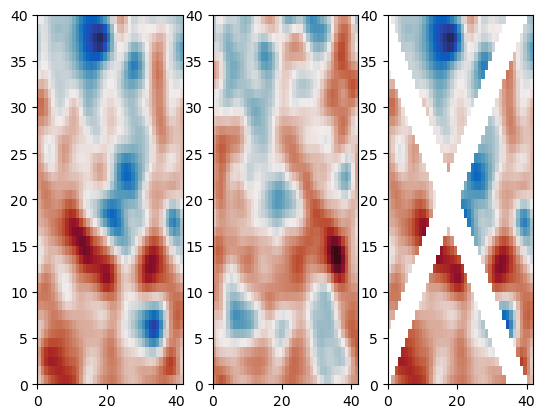

In [29]:
plt.subplot(1,3,1)
plt.pcolormesh(MSLA_fwd[:,:,79], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.subplot(1,3,2)
plt.pcolormesh(MSLA_true[:,:,79], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.subplot(1,3,3)
plt.pcolormesh(msla_out, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
#plt.pcolormesh(MSLA_fwrd_1step[:,:,0], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

In [30]:
#MSLA_fwd_merge=np.concatenate((test, test),axis=0)

In [31]:
# check=MSLA_fwd_merge.reshape(80,40,42)

In [32]:
# check[0,:3,:3]

In [33]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

In [34]:
# only show error estimate skill greater than -100%
err_est_skill1 = np.ma.masked_less(err_est_skill1, -100)
err_est_skill2 = np.ma.masked_less(err_est_skill2, -100)

# Set figure size and aspect ratio for landscape orientation
fig, ax = plt.subplots(figsize=(10, 5))
ialpha=0

# Define a color sequence for lines for better visibility and differentiation
colors = ['blue', 'orange', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive', 'navy']

# Line plots
# ax.plot(time[0:time_range], (1- variance_explained_in_1step[:,1,:].mean(axis=0))*100, label='In-swath Variance (1 step)', linewidth=1.5, color=colors[0], linestyle = '-')
# ax.plot(time[0:time_range], (1-variance_explained_out_1step[:,1,:].mean(axis=0))*100, label='Out-of-swath Variance (1 step)', linewidth=1.5, color=colors[1], linestyle = '-.')
# ax.plot(time[0:time_range], (1-variance_explained_in_2step[:,1,:].mean(axis=0))*100, label='In-swath Variance (2 step)', linewidth=1.5, color=colors[2], linestyle = '-')
# ax.plot(time[0:time_range], (1-variance_explained_out_2step[:,1,:].mean(axis=0))*100, label='Out-of-swath Variance (2 step)', linewidth=1.5, color=colors[3], linestyle = '-.')
# ax.plot(time[0:time_range], (1-variance_explained_1step[:,1,:].mean(axis=0))*100, label='Total Variance (1 step)', linewidth=1.5, color=colors[8], linestyle = '--')
# ax.plot(time[0:time_range], (1-variance_explained_2step[:,1,:].mean(axis=0))*100, label='Total Variance (2 step)', linewidth=1.5, color=colors[9], linestyle = '--')
# ax.plot(time[0:time_range], (1- variance_explained_in_1step[0,0,:])*100, label='In-swath Variance (1 step)', linewidth=1.5, color=colors[0], linestyle = '-')
# ax.plot(time[0:time_range], (1-variance_explained_out_1step[0,0,:])*100, label='Out-of-swath Variance (1 step)', linewidth=1.5, color=colors[1], linestyle = '-.')
# ax.plot(time[0:time_range], (1-variance_explained_in_2step[0,0,:])*100, label='In-swath Variance (2 step)', linewidth=1.5, color=colors[2], linestyle = '-')
# ax.plot(time[0:time_range], (1-variance_explained_out_2step[0,0,:])*100, label='Out-of-swath Variance (2 step)', linewidth=1.5, color=colors[3], linestyle = '-.')
# ax.plot(time[0:time_range], (1-variance_explained_1step[0,0,:])*100, label='Total Variance (1 step)', linewidth=1.5, color=colors[8], linestyle = '--')
# ax.plot(time[0:time_range], (1-variance_explained_2step[0,0,:])*100, label='Total Variance (2 step)', linewidth=1.5, color=colors[9], linestyle = '--')
ax.errorbar(range(time_range), (1- variance_explained_in_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_1step[:,ialpha,:].std(axis=0), label='In-swath Variance (1 step)', elinewidth=1.5, color=colors[0])
ax.errorbar(range(time_range), (1-variance_explained_out_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_in_2step[:,ialpha,:].std(axis=0), label='Out-of-swath Variance (1 step)', elinewidth=1.5, color=colors[1])
ax.errorbar(range(time_range), (1-variance_explained_in_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_1step[:,ialpha,:].std(axis=0), label='In-swath Variance (2 step)', elinewidth=1.5, color=colors[2])
ax.errorbar(range(time_range), (1-variance_explained_out_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_out_2step[:,ialpha,:].std(axis=0), label='Out-of-swath Variance (2 step)', elinewidth=1.5, color=colors[3])
ax.errorbar(range(time_range), (1-variance_explained_1step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_1step[:,ialpha,:].std(axis=0), label='Total Variance (1 step)', elinewidth=1.5, color=colors[8])
ax.errorbar(range(time_range), (1-variance_explained_2step[:,ialpha,:].mean(axis=0))*100, yerr=100*variance_explained_2step[:,ialpha,:].std(axis=0), label='Total Variance (2 step)', elinewidth=1.5, color=colors[9])
# Dashed vertical line at x = 40
ax.axvline(time_range//2, color='gray', linestyle='--', label="Forecast Start")

# Adjust plot properties for better clarity
# ax.set_title('SSH Variance Explained', fontsize=16, fontweight='bold')
ax.set_xlabel('Time (days from initialization)', fontsize=14)
ax.set_ylabel('% Variance Explained', fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position and size
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.legend( fontsize=8)
plt.tight_layout()
plt.savefig('explained_variance_'+ str(int((day1 - day0))) +'days_'+ str(date_time[0])[:10] +'.png', dpi=300)
plt.show()

In [51]:
# variance_explained_in_1step.std

(5, 2, 80)

<ErrorbarContainer object of 3 artists>

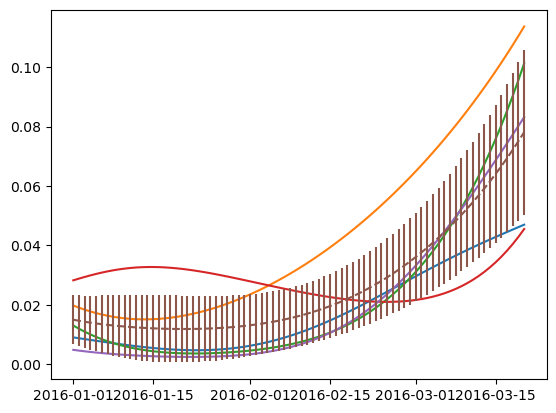

In [57]:
# for i in range(5):
#     plt.plot(time[0:time_range],variance_explained_in_1step[i,1,:])
    
# plt.errorbar(time[0:time_range],variance_explained_in_1step[:,1,:].mean(axis=0),yerr=variance_explained_in_1step[:,1,:].std(axis=0),linestyle='--')


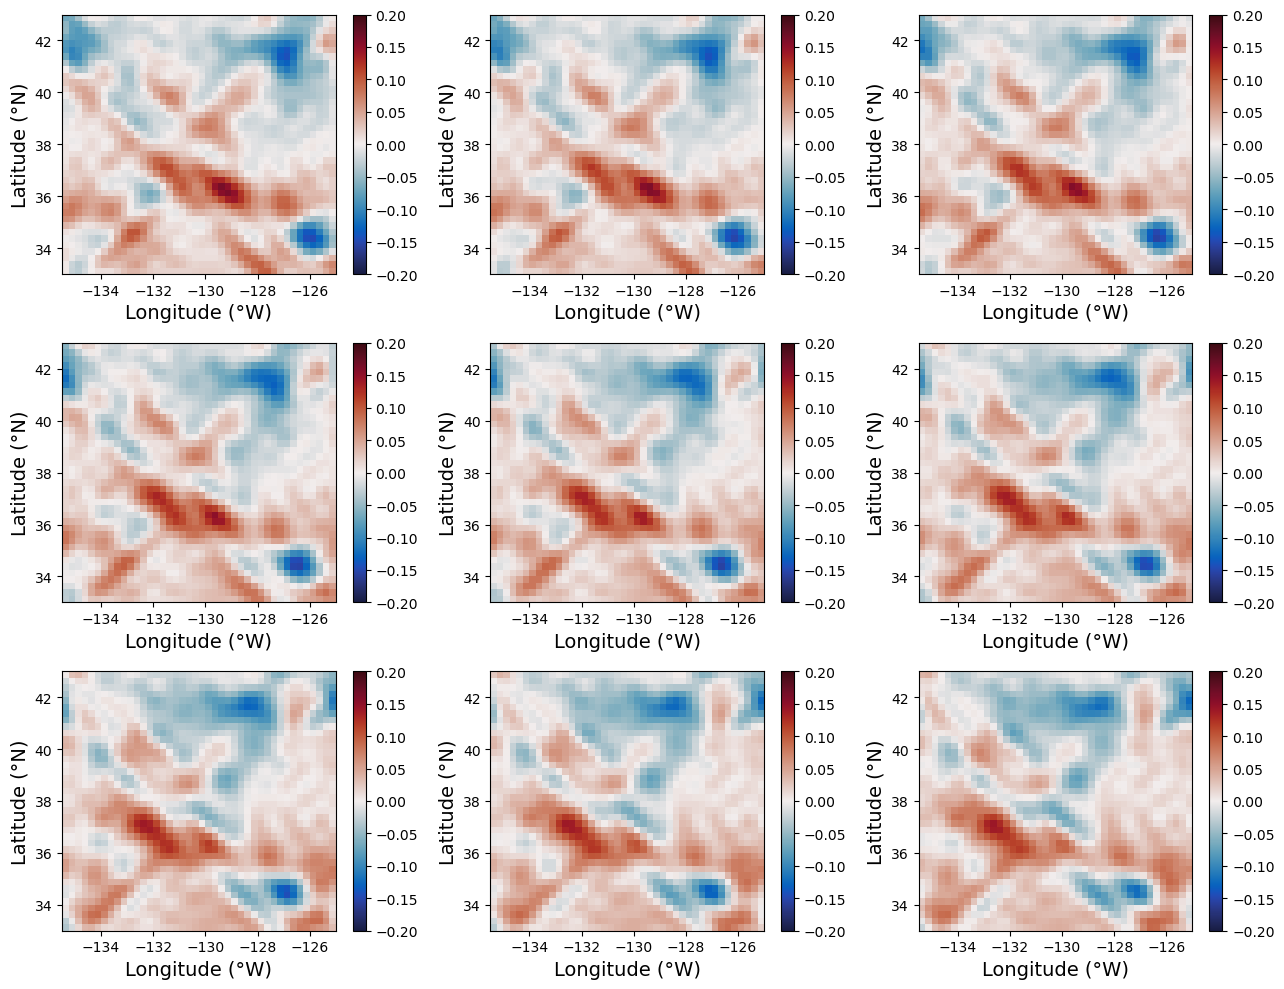

In [63]:
fig = plt.figure(figsize = (13, 10))

icounter=0
for i in [0, 10, 20, 30, 40, 50, 60, 70, 79]:
    icounter=icounter+1
    plt.subplot(3,3,icounter)
    plt.pcolormesh(lon, lat, MSLA_fwrd_2step[:,:,i], cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    
plt.tight_layout()

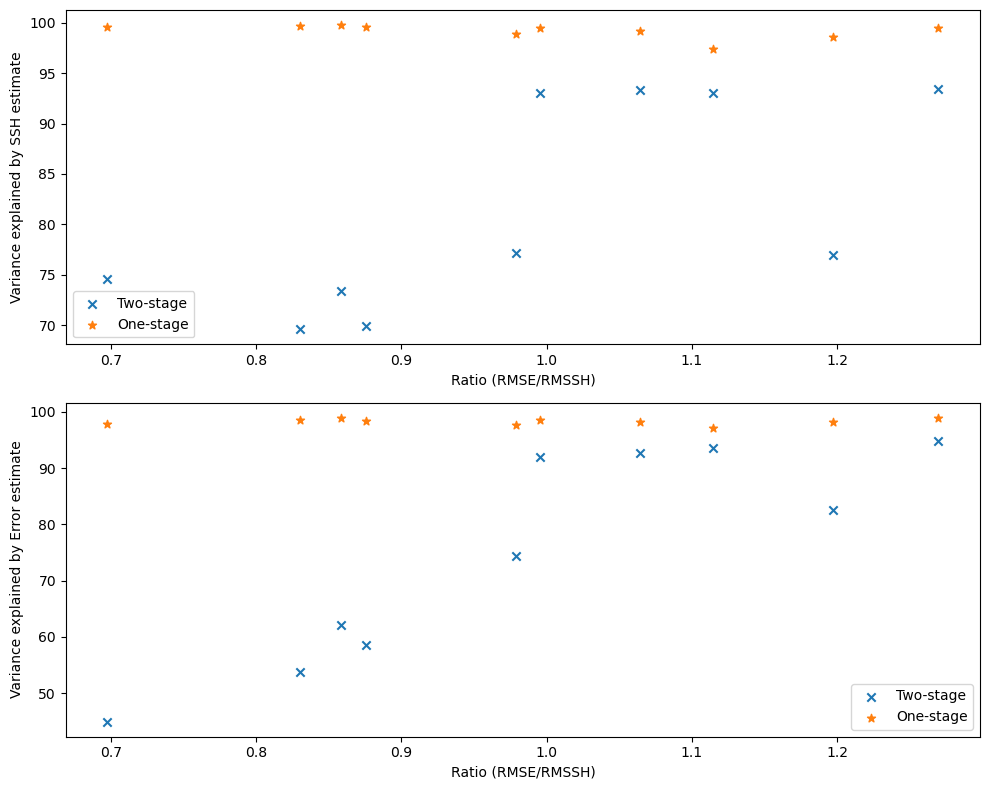

In [37]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')

axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Variance explained by SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Variance explained by Error estimate')

# Add titles
# axs[0].set_title('Skill in SSH estimate for different RMSE values')
# axs[1].set_title('Skill in Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()
#plt.show()
plt.savefig('skill_ssh_errr_rmse_ratio'+ start_date +'.png', dpi = 300)

In [38]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)
err_est_skill2_mean = err_est_skill2.mean(axis = 0)

In [39]:
# only show error estimate skill greater than -100%
err_est_skill1_mean = np.ma.masked_less(err_est_skill1_mean, -100)
err_est_skill2_mean = np.ma.masked_less(err_est_skill2_mean, -100)

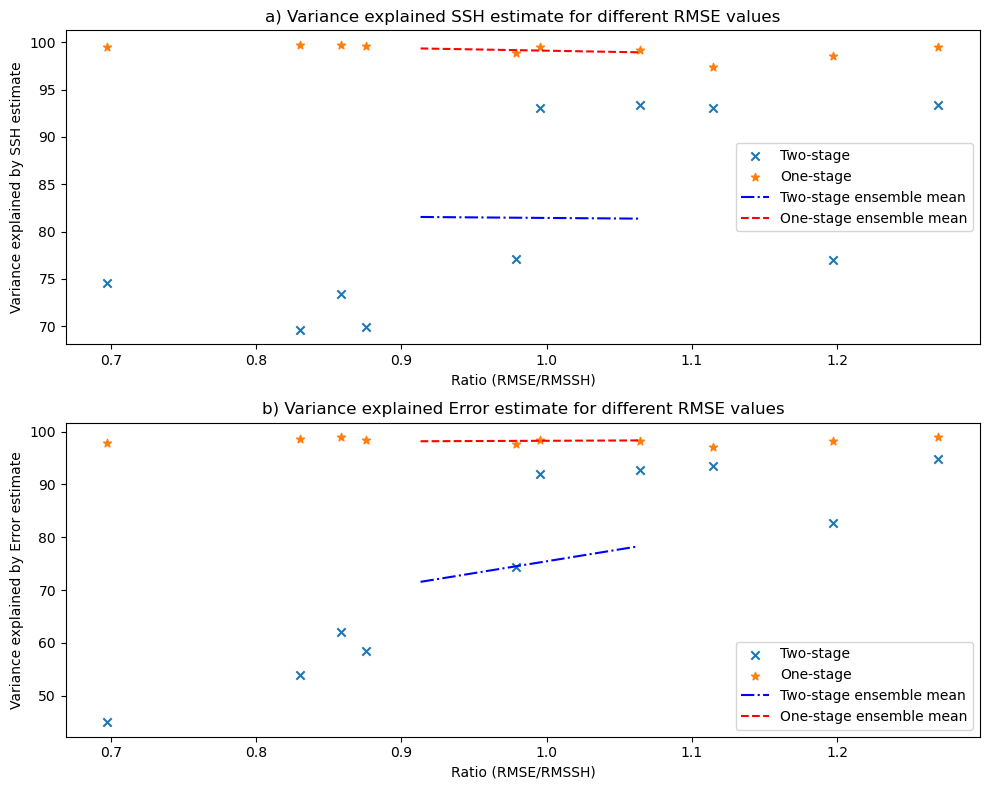

In [40]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh, ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')
axs[0].plot(ratio_mean , ssh_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[0].plot(ratio_mean, ssh_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')


axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')
axs[1].plot(ratio_mean , err_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[1].plot(ratio_mean , err_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Variance explained by SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Variance explained by Error estimate')

# Add titles
axs[0].set_title('a) Variance explained SSH estimate for different RMSE values')
axs[1].set_title('b) Variance explained Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()

plt.savefig('skill_ssh_errr_rmse_ratio_mean'+ start_date +'.png', dpi = 300)

In [41]:
# ratio_mean * 100, alpha_std, rmse_over_rmssh[:, 0]

(array([ 91.32136886, 106.30167287]),
 array([0.01 , 0.011]),
 array([0.83039747, 0.97872297, 1.06413521, 0.9951934 , 0.6976194 ]))

In [42]:
ssh_est_skill2_mean

array([81.54419951, 81.36946333])

In [43]:
ssh_est_skill1_mean

array([99.34530774, 98.93918014])

In [44]:
ssh_est_1step

array([0.02568579, 0.02017217, 0.02219809, ..., 0.07587601, 0.08719279,
       0.08029204])

In [45]:
# mean error in meters
# rms_err.mean(axis = 0)

array([0.04601814, 0.05356714])

In [46]:
err_est_skill1_mean

masked_array(data=[98.15861121, 98.31378836],
             mask=False,
       fill_value=1e+20)

In [47]:
# H_all0.shape, H_all.shape

NameError: name 'H_all0' is not defined

In [ ]:
# plt.subplot(1,3,1)
# plt.pcolormesh(H_all0)
# plt.subplot(1,3,2)
# plt.pcolormesh(H_all)
# plt.subplot(1,3,3)
# plt.pcolormesh(H_all0-H_all)

In [ ]:
# plt.subplot(1,3,1)
# plt.pcolormesh(H_all0)
# plt.subplot(1,3,2)
# plt.pcolormesh(H_all)
# plt.subplot(1,3,3)
# plt.pcolormesh(H_all0-H_all)